#### Evaluation: Cut Graph

This code have been used to evaluate diferent aspects of the recursive bipartition of the Appearance Graph.

For this task its uses the functions implemented in the code 'VisualPlaceRecognition_EvaluationTools'.

In [ ]:
import json
import h5py
import imageio
import matplotlib.pyplot as plt
import os
import matplotlib
import shutil 
import numpy as np
from PIL import Image
from matplotlib import image
import seaborn as sb
from Utils import load_utils
from IPython.display import clear_output

from Utils import geometry2 as geo
from scipy.spatial.transform import Rotation as R
from scipy.spatial.distance import cdist 
from Utils import load_utils
import random

In [2]:
import sys
def sizeof_fmt(num, suffix='B'):
    ''' by Fred Cirera,  https://stackoverflow.com/a/1094933/1870254, modified'''
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)

### Weighted Graph 
#### Class definition

In [3]:
# my_similarity returns the similarity between all elements of a set

def my_similarity(data_set,sim_f):
    print('-STEP 1: Compute simalarity matrix throught map features.')
    features=np.array(data_set['features'])
    size=len(features)
    print('Feature size: ',size)
    n_iter=(size**2 +size)/2
    cont=0
    sim=[[0 for i in range(size)] for j in range(size)]
    for i in range(0,size):
        for j in range(i,size):         
            similarity=sim_f(features[i],features[j])
            sim[i][j]=similarity
            sim[j][i]=similarity
            
            del similarity
            print('Process: ',np.round(((100*cont)/n_iter),2),' %',end='\r')
            cont+=1
    print('FINISH.',end='\n------------------------------------------------------\n')
    return np.array(sim)

In [4]:
#Get NetVLAD descriptors:
def get_descriptor(general_path):
    descriptors=[]
    for suffix in os.listdir(general_path):
        f=h5py.File(general_path+suffix,'r')
        descriptors+=f['features']
    return np.array(descriptors)

In [5]:
#This function searh for connected nodes. Used to check graph's connectinity
def dfs(visited, graph, index=0):
    if index not in visited:
        visited.append(index)
        adj_idx=np.argwhere(graph[index,:]==1)
        adj_idx=np.reshape(adj_idx,[-1])
        for neighbour in adj_idx:
            dfs(visited, graph, neighbour)

In [6]:
def aux_plot_map(poses,subgraphs):
    max_x=0
    max_y=0
    max_tam=0
    map_x=0
    map_y=0

    map_pose=geo.combine(poses)

    for k in range(len(subgraphs)):
        poses_cl=poses[subgraphs[k]]
        cluster_poses=geo.combine(poses_cl)
        
        for i in range(len(poses_cl)):
            pq=poses_cl[i]

            #Compute pose decomposition
            incre= pq / cluster_poses
            dist_x = [(incre.t()[i][0]) for i in range(len(incre))]
            dist_y = [(incre.t()[i][1]) for i in range(len(incre))]
            
            if max_x < np.max(dist_x): max_x = np.max(dist_x)
            if max_y < np.max(dist_y): max_y = np.max(dist_y)

            #Compute pose decomposition for the hall map
            incre= pq / map_pose
            dist_x_map = [(incre.t()[i][0]) for i in range(len(incre))]
            dist_y_map = [(incre.t()[i][1]) for i in range(len(incre))]

            if map_x < np.max(dist_x_map): map_x = np.max(dist_x_map)
            if map_y < np.max(dist_y_map): map_y = np.max(dist_y_map)

        if max_tam < len(subgraphs[k]): max_tam = len(subgraphs[k])
    return max_x, max_y, max_tam, map_x, map_y
        

In [48]:
class weighted_graph:    
    def __init__(self, weights, sim_matrix, data_set, db_name, peso, criterion):
        
        self.data_set=data_set
        self.db=db_name

        if criterion == 'A':
            self.weights=weights*sim_matrix                 # Multiplicacion elemento a elemento
            
        elif criterion == 'B':
            self.weights=2/((1/weights)+(1/sim_matrix))     # Media armonica

        elif criterion == 'C':
            self.weights=(weights*sim_matrix)**(1/2)        # Media geometrica

        elif criterion == 'D':
            self.weights=(peso*weights+((2-peso)*np.array(sim_matrix)))/2  # Media ponderada
        
        elif criterion == 'E':
            self.weights=weights        # Just co-visibility matrix

        elif criterion == 'F':
            self.weights=np.array(sim_matrix)     # Just similarity matrix

        self.subgraphs=[[x for x in range(len(self.weights))]] #Clusters list

        self.check_connectivity()
        

    def check_connectivity(self):
        print('-STEP 2: Checking graph connectivity.')
        adjacent_graph=np.abs(np.sign(self.weights))
        tam=adjacent_graph.shape[0]
        nodes=np.arange(tam,dtype=int)
        visited=[]
        old=[]
        idx=0
        dfs(visited, adjacent_graph, idx)
        if (len(visited)<tam): 
            print('Unconnected graphs founds - Splitting')
            self.subgraphs.pop(0)
            while len(visited)<tam:
                new_subgraph=np.setdiff1d(visited,old)
                new_subgraph=np.array(new_subgraph).tolist()
                self.subgraphs.append(new_subgraph)
                miss= np.setdiff1d(nodes,visited)
                if len(miss)>0:  
                    idx=miss[0]
                    old=np.copy(visited)
                    dfs(visited, adjacent_graph, idx)
            new_subgraph=np.setdiff1d(visited,old)
            new_subgraph=np.array(new_subgraph).tolist()
            self.subgraphs.append(new_subgraph) 
        print('Nº of inconected inside graphs: ', len(self.subgraphs))
        print('FINISH.',end='\n------------------------------------------------------\n')

    def get_idx(self,subgraph): #Map the images index with databse index -- Worthy just in case images index desordered 
        idx=[]
        for item in subgraph:  
            idx.append(self.idx[item])
        idx=np.sort(idx)
        return idx

    def cut(self,subgraphA,subgraphB): 
        return self.weights[subgraphA][:,subgraphB].sum()
    
    def assoc(self,graph,subgraph): 
        return self.weights[subgraph][:,graph].sum()
    
    def ncut(self,graph,subgraphA,subgraphB): 
        return (self.cut(subgraphA,subgraphB)/self.assoc(graph,subgraphA))+(self.cut(subgraphA,subgraphB)/self.assoc(graph,subgraphB))
    
    def weighted_ncut(self,graph,subgraphA,subgraphB): 
        total_size=len(subgraphA)+len(subgraphB)
        #wA=len(subgraphA)/total_size
        #wB=len(subgraphB)/total_size
        wA=np.exp(-len(subgraphA)/total_size)
        wB=np.exp(-len(subgraphB)/total_size)
        return wA*(self.cut(subgraphA,subgraphB)/self.assoc(graph,subgraphA))+wB*(self.cut(subgraphA,subgraphB)/self.assoc(graph,subgraphB))
    
    def spectralbisection(self,graph_indices):
        D=np.diag(self.weights[graph_indices][:,graph_indices].sum(0))
        Laplacian=np.array(D-self.weights[graph_indices][:,graph_indices],dtype=np.float64)

        eigenvalues, eigenvectors=np.linalg.eigh(Laplacian)  #This solves standard and generalized eigenvalue problems
        partition=eigenvectors[:, np.argsort(eigenvalues)[1]] #We need to pick the eigenvector associated with the 2nd smallest eigenvalue

        #We will form two groups: positive and negative coordinates
        return [graph_indices[i] for (i, x) in enumerate(partition) if x < 0], \
                   [graph_indices[i] for (i, x) in enumerate(partition) if x >= 0]
    
    def sort_clusters(self):
        n_clusters=len(self.subgraphs)
        for i in range(n_clusters):
            for j in range(0,n_clusters-i-1):
                if self.subgraphs[j][0]>self.subgraphs[j+1][0]:
                    self.subgraphs[j],self.subgraphs[j+1]=self.subgraphs[j+1],self.subgraphs[j]
        return self.subgraphs
    
    def make_gifs(self):
        main_path='.../Clusters_gifs' # Path to save gifs
        clusters_path=main_path+self.db+"/Clusters_gifs"

        if os.path.exists(clusters_path):
            shutil.rmtree(clusters_path)   #Deletes the content of the folder 
        os.makedirs(clusters_path)

        #Create the gifs 
        n_clusters=len(self.subgraphs)
        pic_path='.../map/Images/'  # Dataset Image Directory
        for i in range(n_clusters):
            idx=self.get_idx(self.subgraphs[i])
            images=[]
            for j in idx:
                images.append(Image.open(pic_path+cold_dataset['im_paths'][j]))
            images[0].save(clusters_path+'/Cluster '+str(i+1)+'.gif',
               save_all=True,
               append_images=images[1:],
               duration=100,
               loop=1)  
    
    def folders(self):  
        # Function to create folders with subgraph images

        clusters_path=".../Clusters_folder" # Path to save image folders

        # Create folder
        if not os.path.exists(clusters_path):
            os.makedirs(clusters_path)
        shutil.rmtree(clusters_path)   # Deletes the content of the folder

        # Create folder with the subgraph images
        pic_path='.../map/Images/'  # Dataset Image Directory
        n_clusters=len(self.subgraphs)
        for i in range(n_clusters): # Traverse set of subgraphs
            try:
                # Create folder for the subgraph
                new_path=clusters_path+"/Cluster_"+str(i+1)
                if not os.path.exists(new_path):
                    os.makedirs(new_path)
                
                # Store images of the subgraph
                for item in self.subgraphs[i]:
                    original=pic_path+self.data_set['im_paths'][item] 
                    target=new_path+"/"+self.data_set['im_paths'][item]
                    shutil.copyfile(original, target)

            except OSError:
                print ('Error: Creating folder. ' +  new_path)
                
    def check_repited_nodes(self):
        res_index=[]
        for j in range(len(self.subgraphs)-1):
            for item in self.subgraphs[j]:
                for i in range(j+1,len(self.subgraphs)):
                    if item in self.subgraphs[i]: res_index.append({'Nodo': item, 'indice': i})
        return res_index
        
    def clusters_recursive(self, graph, sup_thr, weighted, eval_tend):
        cut_value=2

        if graph is not None and len(graph) > 1 :
            group_A,group_B=self.spectralbisection(graph)

            if (group_A is not None and group_B is not None):

                if weighted == True:
                    cut_value=self.weighted_ncut(graph,group_A,group_B)
                else:
                    cut_value=self.ncut(graph,group_A,group_B)
        
                #Recursive cluster cut:
                cut_A, cluster_A = self.clusters_recursive(group_A, sup_thr, weighted, eval_tend)
                cut_B, cluster_B = self.clusters_recursive(group_B, sup_thr, weighted, eval_tend)
                
                #Remove stored data
                graph=np.union1d(cluster_A,cluster_B).tolist()
                graph=[int(x) for x in graph]
                
                if eval_tend == True:
                    if cut_value < sup_thr:
                        if len(cluster_A)>2 and (cut_value < cut_A or cut_value < cut_B): 
                            self.subgraphs.append(cluster_A)
                            graph=np.setdiff1d(graph,cluster_A).tolist()   
                        
                        if len(cluster_B)>2 and (cut_value < cut_A or cut_value < cut_B):
                            self.subgraphs.append(cluster_B)
                            graph=np.setdiff1d(graph,cluster_B).tolist()    
                
                else:
                    if cut_value < sup_thr:
                        if len(cluster_A)>2: 
                            self.subgraphs.append(cluster_A)
                            graph=np.setdiff1d(graph,cluster_A).tolist()    
                        
                        if len(cluster_B)>2: 
                            self.subgraphs.append(cluster_B)
                            graph=np.setdiff1d(graph,cluster_B).tolist()   
                    

        return cut_value, graph
              
    
    
    def clusters(self, sup_thr, tam_weighted, eval_tend):
        subgraph_copy=self.subgraphs.copy()

        self.subgraphs=[]
        loss_idx=[]
        for i in range(len(subgraph_copy)):
            cut_val, graph = self.clusters_recursive(subgraph_copy[i], sup_thr, tam_weighted, eval_tend)
            loss_idx.extend(graph)
            if len(graph) > 2: self.subgraphs.append(graph)
            print('Last graph non-cutted: ',cut_val, graph)
        
        self.loss_idx=loss_idx
        self.sort_clusters()
        #self.make_gifs()
        #self.folders()
        return self.subgraphs
    
    def bad_clusters(self,ncut_thr=0.7):
        index=0
        cut_arr=[]
        tam=len(self.weights)
        while index<len(self.subgraphs):
            #Check if there is unconected nodes and separe, 2º smalller eigvalue<0
            if len(self.subgraphs[index])>1:
                group_A,group_B=self.spectralbisection(self.subgraphs[index])
                #print('Tamaño grupo A: ', len(group_A))
                #print('Tamaño grupo B: ', len(group_B))
                if len(group_A)>0 and len(group_B)>0:
                    cut_val=self.ncut(self.subgraphs[index],group_A,group_B)
                    cut_store={
                        'Ncut' : cut_val,
                        'Len(A)' : len(group_A),
                        'Len(B)' : len(group_B)}
                    cut_arr=np.append(cut_arr,cut_store)
                    if len(group_A)>100 or len(group_B)>100: print('Valor del corte: ',cut_val)
                   
                    if cut_val<=ncut_thr: # and len(group_A)>20 or len(group_B)>20:
                        self.subgraphs.pop(index)
                        self.subgraphs.append(group_A)
                        self.subgraphs.append(group_B)
                        #self.sort_tam()
                    else: index+=1
                else: 
                    print('Error: Subgrupo vacío.')
                    index+=1
            else: index+=1
   
                
        #self.folders()
        self.loss_idx=[]
        self.sort_clusters()
        #self.make_gifs()
        return self.subgraphs, cut_arr  
    
    def classification(self):
        #Function returns classification vector with the clusters index for each position
        classif=[0 for i in range(len(self.data_set['poses']))]
        for i,cluster in enumerate(self.subgraphs):
            for index in cluster:
                #print(index)
                classif[index]=i
        
        self.classif=classif
        return classif

    def create_map(self, map_path, save=False):
        map={}

        map['im_paths']=self.data_set['im_paths']
        map['poses']=self.data_set['poses']
        map['odom_poses']=self.data_set['odom_poses']
        map['features']=self.data_set['features']
        map['seq']=self.data_set['seq']
        map['test']=self.data_set['test']
        map['clusters_list']=self.subgraphs
        map['clusters_idx']=self.classification()
        
        if save:
            with open(map_path, "w") as outfile:
                json.dump(map, outfile)
        
        return map

    def plot_map(self,path, eval_arr, text=False, save=False):
        n_clusters=len(self.subgraphs)
        my_colors=sb.color_palette('turbo',n_clusters) 
        random.shuffle(my_colors)
        #my_colors=sb.color_palette('turbo',10) 

        train_dataset = load_utils.load_sequence(self.data_set,verbose=False)
        poses = train_dataset['poses']

        plt.figure(figsize=(14,23))
        plt.plot(0,0,marker='*',color='red')
        
        if text == True:
            max_x,max_y,max_tam, map_x, map_y=aux_plot_map(poses,self.subgraphs)
            my_text='Numero de cluster :'+str(len(self.subgraphs))+'\n Max nº nodos en cluster : '+str(max_tam)+'\n\nMap size in meters: ('+str(map_x)+','+str(map_y)+')\nMax. Dist_x rn cluster: '+str(max_x)+'\nMax. Dist_y en cluster: '+str(max_y)+'\nMax. Dist en x: '+str(max_x)+'\nMax. Dist en y: '+str(max_y)
            plt.text(2,3,my_text)
            
            my_text='SH map= '+str(np.round(eval_arr[0],6))+'\nSH query= '+str(np.round(eval_arr[1],6))+'\nP mean on cluster = '+str(np.round(eval_arr[2],6))+'\nR mean on cluster = '+str(np.round(eval_arr[3],6))+'\nP overall = '+str(np.round(eval_arr[4],6))+'\nACC overall = '+str(np.round(eval_arr[5],6))
            plt.text(2,-3,my_text)
        
        for i in range(n_clusters):

            for item in (self.subgraphs[i]):
                #classif_idx=self.subgraphs[i][j]
                translation=geo.SE2Poses.t(poses[item])
                new_x=translation[0]
                new_y=translation[1]   
                plt.plot(-new_y,new_x,markersize=2.5,marker='o',color=my_colors[i]) #[cluster_clas_bin[classif_idx]-1])
            
            for k in self.loss_idx:
                translation=geo.SE2Poses.t(poses[k])
                loss_x=translation[0]
                loss_y=translation[1]   
                plt.plot(-loss_y,loss_x,markersize=3.5,marker='x',color='black') #[cluster_clas_bin[classif_idx]-1])
            #plt.text(-new_y + 0.1, new_x + 0.1, str(classif[classif_idx]))
            plt.plot(-new_y,new_x,markersize=4,marker='X',color='black')
            plt.axis('off')
            plt.xlim([-2.5,7.5])
            plt.ylim([-20,10])

        if save:
            plt.savefig(path)

### Load Files

Generate map.json with features and poses

In [ ]:
cloudy_path=".../dataset/map/"

cold_dataset=dict(im_paths=[], poses=[], odom_poses=[], features=[], seq=[], test=[])

#Load poses and paths:
for json_suffix in os.listdir(cloudy_path+"Poses/"):
    json_file=json.load(open(cloudy_path+"Poses/"+json_suffix)) 
    samples=len(json_file['im_paths'])
    cold_dataset['im_paths']+=json_file['im_paths']
    cold_dataset['poses']+=json_file['poses']
    cold_dataset['odom_poses']+=json_file['odom_poses']
    cold_dataset['seq']+=[json_suffix[3]]*samples
    cold_dataset['test']+=[json_suffix[11]]*samples  
#Load image descriptors:
descr_path=cloudy_path+'Descriptors/'+'netVLAD/'
features= get_descriptor(descr_path).tolist()
cold_dataset['features']+=features

print('Tamaño del dataset: ', len(cold_dataset['features']))

Load co-visibility and similarity matrix

In [9]:
cov_path=".../outputs/cov_matrix.npy"
sim_path=".../outputs/sim_matrix.npy"

descr_path=".../dataset/map/Descriptors/netVLAD/"

#Load co-visibility matrix
weight=np.load(cov_path)
sim_matrix=np.load(sim_path)
tam=weight.shape[0]
weight=np.float64(weight[0:tam,0:tam])  # Assert Square matrix
print('Tamaño original weight mat: ',weight.shape)

Tamaño original weight mat:  (2146, 2146)


## Evaluation - Criterion to make the bipartition of the graph

In this section we evaluate the different methods to weight the value of the Ncut that determine the bipartition of the subgraphs.
We iterate over 2 parameters:

     - eval_tend = Parameter that is used to compare the trend of the value of Ncut from the parent node to its children
         If it takes the value True, the graph cut is performed only if Ncut_father < Ncut_children & Ncut < threshold
         Otherwise, the graph is cut only if Ncut_father < threshold
    
     - tam weighted = If it takes the value True, each element of the Ncut operation is weighted by the exponential number of nodes of each subgraph over the total
         wA=np.exp(sizeA/size_total)
         Ncut= wA x (cut(A,B)/assoc(A,V)) + wB x (cut(A,B)/assoc(B,V))

Only 1 method is evaluated to calculate the weight matrix with the different configurations

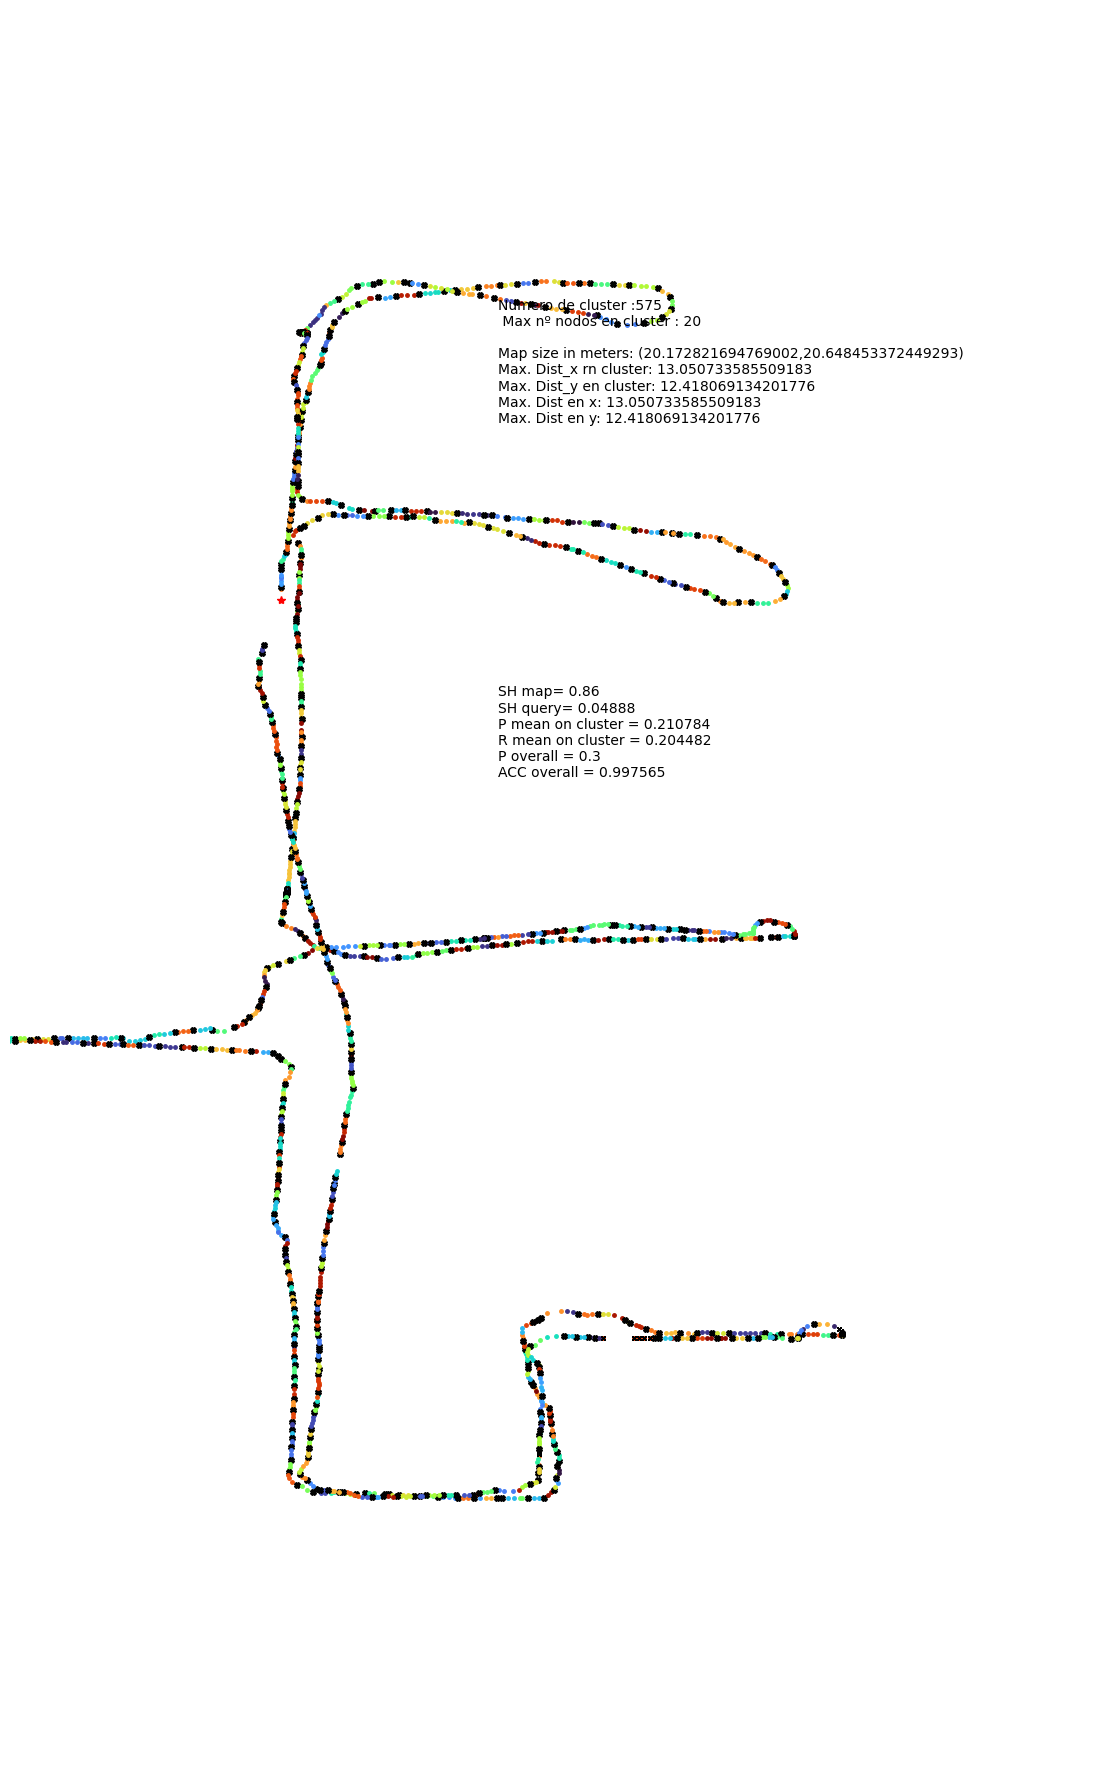

In [19]:
#Config array for set eval_tend, tem_weight:
eval_tend_arr=[False,True,False,True]
tam_weighted_arr=[False,False,True,True]
config_arr=(eval_tend_arr,tam_weighted_arr)

#Set evaluation parameters:
test_crit='C'
ncut_trh=0.65

# Init evaluation result arrays:
query_shscore_mean=[]
map_shscore_mean=[]
cluster_P_mean=[]
cluster_R_mean=[]
overall_P=[]
overall_ACC=[]

my_label=['BaseCase', 'EvalTend', 'TamWeight', 'FullCase']


for v in range(4):

        print('Proceso :',v,'/4')
        print('Create weighted graph class')
        graph=weighted_graph(weight,sim_matrix, cold_dataset,'COLD',peso=1.8,criterion=test_crit)
    
        print('Clustering')
        clusters =graph.clusters(ncut_trh, tam_weighted=config_arr[1][v], eval_tend=config_arr[0][v])
        map_path=".../outputs/eval_map.json"
        map = graph.create_map(map_path,save=True)

        print('Run Place Recognition Evaluation')
        %run Place_Recognition.ipynb

        #Plot and save the map with poses
        print('Index: ',v)
        name='Criterion_'+test_crit+'_config_'+my_label[v]
        path='.../Evaluation/'+name+'.png'
        eval_arr=np.array([map_sh_score_mean,sh_score_mean,P_mean,R_mean,P_,ACC_])
        graph.plot_map(path,eval_arr,save=False)


        query_shscore_mean.append(sh_score_mean)
        map_shscore_mean.append(map_sh_score_mean)
        cluster_P_mean.append(P_mean)
        cluster_R_mean.append(R_mean)
        overall_P.append(P_)
        overall_ACC.append(ACC_)

        clear_output(wait=True)

Plot resultados

Text(0.5, 0, 'Evaluation 1 Result for criterion C')

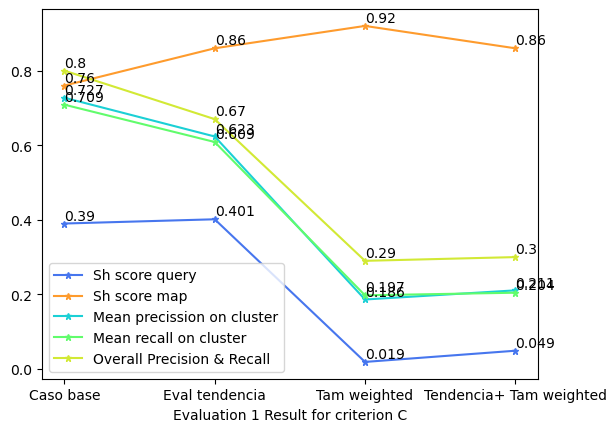

In [23]:
my_label=['Caso base', 'Eval tendencia', 'Tam weighted', 'Tendencia+ Tam weighted']
my_color=sb.color_palette('turbo',6) 

plt_diag=plt.axes()

plt_diag.plot(my_label,query_shscore_mean,marker='*',markersize=5,color=my_color[0],label='Sh score query')
plt_diag.plot(my_label,map_shscore_mean,marker='*',markersize=5,color=my_color[4],label='Sh score map')
plt_diag.plot(my_label,cluster_P_mean,marker='*',markersize=5,color=my_color[1],label='Mean precission on cluster')
plt_diag.plot(my_label,cluster_R_mean,marker='*',markersize=5,color=my_color[2], label='Mean recall on cluster')
plt_diag.plot(my_label,overall_P,marker='*',markersize=5,color=my_color[3], label='Overall Precision & Recall')
#plt_diag.plot(my_label,overall_ACC,marker='*',markersize=5,color=my_color[4], label= 'Overall_ACC')

for i in range(len(query_shscore_mean)):
    plt_diag.text(my_label[i],query_shscore_mean[i]+0.01,np.round(query_shscore_mean[i],3))
    plt_diag.text(my_label[i],map_shscore_mean[i]+0.01,np.round(map_shscore_mean[i],3))
    plt_diag.text(my_label[i],cluster_P_mean[i]+0.01,np.round(cluster_P_mean[i],3))
    plt_diag.text(my_label[i],cluster_R_mean[i]+0.01,np.round(cluster_R_mean[i],3))
    plt_diag.text(my_label[i],overall_P[i]+0.01,np.round(overall_P[i],3))
    #plt_diag.text(my_label[i],overall_ACC[i]+0.01,np.round(overall_ACC[i],3))

plt.legend()
plt.xlabel('Evaluation 1 Result for criterion %s'%(test_crit))

Print analitics result

In [21]:
print('Best sh score intra map: ',my_label[np.argmax(map_shscore_mean)])
print('Best sh score query: ',my_label[np.argmax(query_shscore_mean)])
print('Best P mean on cluster score: ',my_label[np.argmax(cluster_P_mean)])
print('Best R mean on score: ',my_label[np.argmax(cluster_R_mean)])
print('Best P&R overall score: ',my_label[np.argmax(overall_P)])
print('Best Accuracy overall score: ',my_label[np.argmax(overall_ACC)])

Best sh score intra map:  Tam weighted
Best sh score query:  Eval tendencia
Best P mean on cluster score:  Caso base
Best R mean on score:  Caso base
Best P&R overall score:  Caso base
Best Accuracy overall score:  Tam weighted


### Conclusion:
Here we indicate the best configurations of the cut for the different methods of calculating the adjacency matrix of the Appearance Graph

Simple element-by-element multiplication:

     Base Case: Best for Q&A at the cluster level
     Tam weight: Best for SH score and P overall

harmonic mean:

     Base Case: Better overall (same as eval pend)

Geometric mean:

     Base Case: Better Overall
     Tam weight: Best for SH intra map
    
Similarity matrix:

     Base Case: It is the best that comes out even though it comes out very badly

## Evaluation - Ncut threshold
In this section, a sweep of the Ncut parameter will be made to determine the range of best performance.

Only one criterion is evaluated to compute the weight matrix with one configuration.

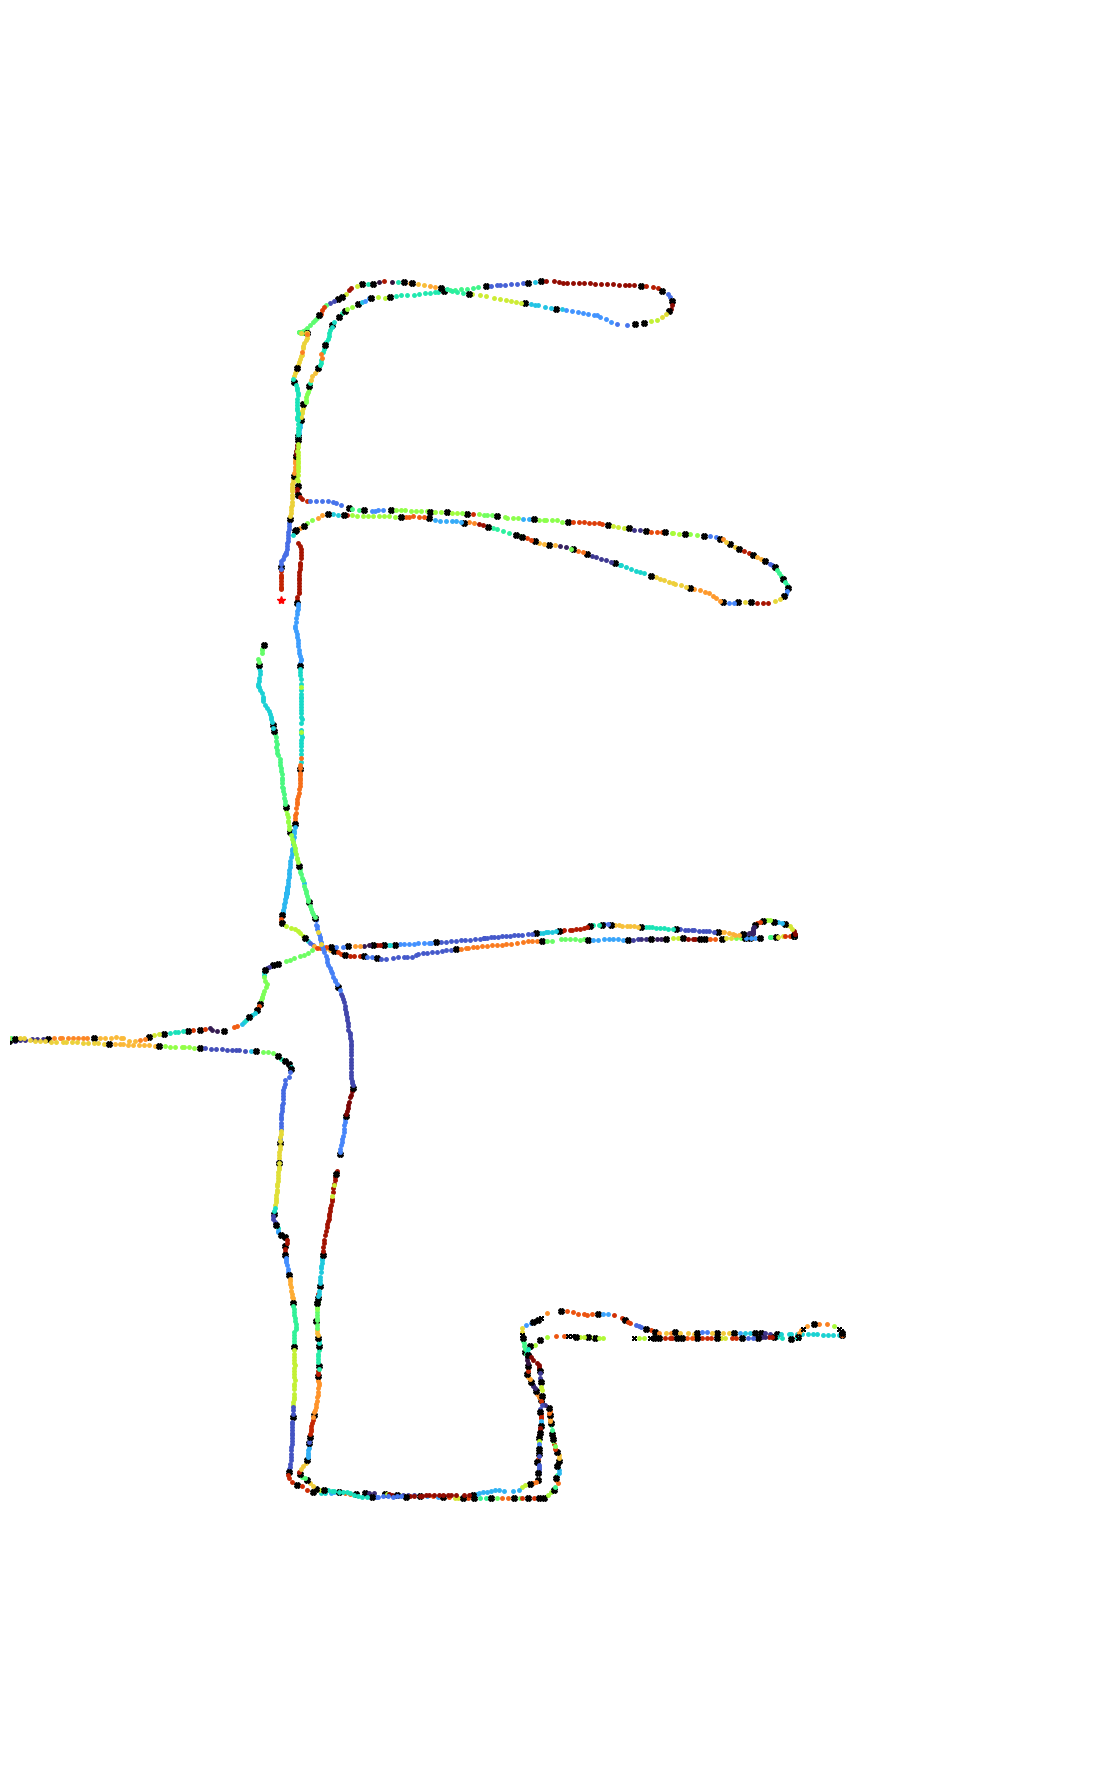

In [38]:
sys.setrecursionlimit(15000000)
#Config threshold array:
thr_arr=np.arange(0.2,0.9,0.05)

#Set evaluation parameters:
test_crit='A'
tam_weight = False
eval_tend = False

# Init evaluation result arrays:
map_shscore_mean=[]
pose_shscore_mean=[]
cluster_P_mean=[]
cluster_R_mean=[]
overall_P=[]
overall_ACC=[]

for v in range(len(thr_arr)):
        print('Proceso :',v,'/',len(thr_arr))

        print('Create weighted graph class')
        graph=weighted_graph(weight,sim_matrix, cold_dataset,'COLD',peso=1.8,criterion=test_crit)
    
        print('Clustering')
        clusters = graph.clusters(thr_arr[v], tam_weight, eval_tend)
        map_path="/outputs/eval_map.json"
        map = graph.create_map(map_path,save=True)
        
        print('Run Place Recognition Evaluation')
        %run Place_Recognition.ipynb

        #Plot and save the map with poses
        print('Index: ',v)
        name='Criterion_'+test_crit+'_Trh_'+str(thr_arr[v])
        path='.../Evaluation/'+name+'.png'
        eval_arr=np.array([map_sh_score_mean,P_mean,R_mean,P_,ACC_])
        graph.plot_map(path,eval_arr,text=False,save=True)

        map_shscore_mean.append((map_sh_score_mean+1)/2)
        cluster_P_mean.append(P_mean)
        cluster_R_mean.append(R_mean)
        overall_P.append(P_)
        overall_ACC.append(ACC_)
        
        clear_output(wait=True)

Plot result

In [55]:
file_path=".../Evaluation/"

cloudy_P_cl=np.load(file_path+"cloudy_P_clusters.npy")
cloudy_R_cl=np.load(file_path+"cloudy_R_clusters.npy")
cloudy_P_overall=np.load(file_path+"cloudy_P_overall.npy")
cloudy_SH=np.load(file_path+"cloudy_SH_map.npy")
cloudy_ACC_overall=np.load(file_path+"cloudy_ACC_overall.npy")

night_P_cl=np.load(file_path+"night_P_clusters.npy")
night_R_cl=np.load(file_path+"night_R_clusters.npy")
night_P_overall=np.load(file_path+"night_P_overall.npy")
night_SH=np.load(file_path+"night_SH_map.npy")
night_ACC_overall=np.load(file_path+"night_ACC_overall.npy")

sunny_P_cl=np.load(file_path+"sunny_P_clusters.npy")
sunny_R_cl=np.load(file_path+"sunny_R_clusters.npy")
sunny_P_overall=np.load(file_path+"sunny_P_overall.npy")
sunny_SH=np.load(file_path+"sunny_SH_map.npy")
sunny_ACC_overall=np.load(file_path+"sunny_ACC_overall.npy")

P/R General + P y R a nivel de cluster

Text(0, 0.5, 'Precisión / Sensibilidad')

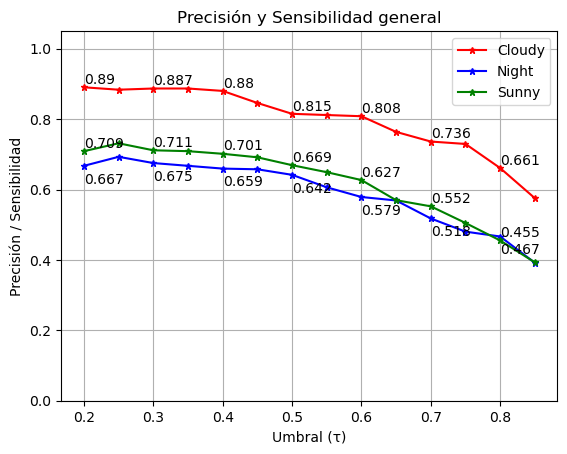

In [96]:
my_color=sb.color_palette('turbo',4) 

plt_diag=plt.axes()

plt_diag.plot(thr_arr,cloudy_P_overall,marker='*',markersize=5,color='r',label='Cloudy')
plt_diag.plot(thr_arr,night_P_overall,marker='*',markersize=5,color='b',label='Night')
plt_diag.plot(thr_arr,sunny_P_overall,marker='*',markersize=5,color='g',label='Sunny')

for i in range(len(cloudy_P_overall)):
    if i%2==0:
        plt_diag.text(thr_arr[i],cloudy_P_overall[i]+0.01,np.round(cloudy_P_overall[i],3))
        plt_diag.text(thr_arr[i],night_P_overall[i]-0.05,np.round(night_P_overall[i],3))
        plt_diag.text(thr_arr[i],sunny_P_overall[i]+0.01,np.round(sunny_P_overall[i],3))


plt.legend()
plt.grid()
plt.title('Precisión y Sensibilidad general')
plt.ylim([0,1.05])
plt.xlabel('Umbral (τ)')
plt.ylabel('Precisión / Sensibilidad')

Text(0, 0.5, 'Exactitud (ACC)')

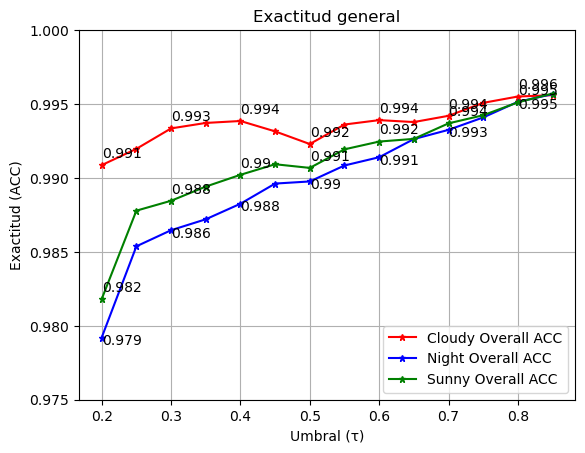

In [108]:
my_color=sb.color_palette('turbo',4) 

plt_diag=plt.axes()

plt_diag.plot(thr_arr,cloudy_ACC_overall,marker='*',markersize=5,color='r',label='Cloudy Overall ACC')
plt_diag.plot(thr_arr,night_ACC_overall,marker='*',markersize=5,color='b',label='Night Overall ACC')
plt_diag.plot(thr_arr,sunny_ACC_overall,marker='*',markersize=5,color='g',label='Sunny Overall ACC')

for i in range(len(cloudy_ACC_overall)):
    if i%2==0:
        plt_diag.text(thr_arr[i],cloudy_ACC_overall[i]+0.0005,np.round(cloudy_ACC_overall[i],3))
        plt_diag.text(thr_arr[i],night_ACC_overall[i]-0.0005,np.round(night_ACC_overall[i],3))
        plt_diag.text(thr_arr[i],sunny_ACC_overall[i]+0.0005,np.round(sunny_ACC_overall[i],3))

plt.legend(loc='lower right')
plt.grid()
plt.title('Exactitud general')
plt.ylim([0.975,1])
plt.xlabel('Umbral (τ)')
plt.ylabel('Exactitud (ACC)')

Text(0.5, 1.0, 'Curva de Precisión media a nivel de grupos')

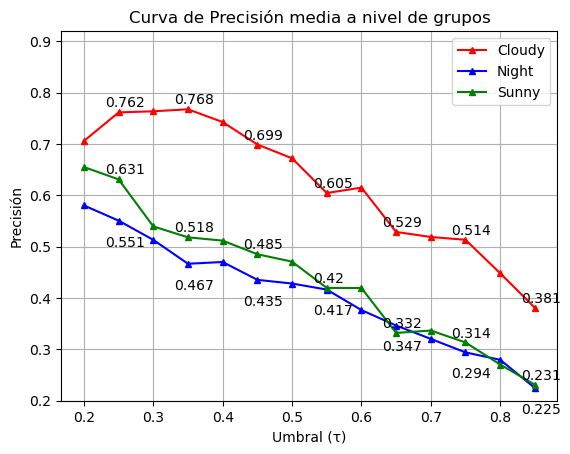

In [132]:
my_color=sb.color_palette('turbo',4) 

plt_diag=plt.axes()

plt_diag.plot(thr_arr,cloudy_P_cl,marker='^',markersize=5,color='r',label='Cloudy')
plt_diag.plot(thr_arr,night_P_cl,marker='^',markersize=5,color='b',label='Night')
plt_diag.plot(thr_arr,sunny_P_cl,marker='^',markersize=5,color='g',label='Sunny')

for i in range(len(cloudy_ACC_overall)):
    if i%2!=0:
        plt_diag.text(thr_arr[i]-0.02,cloudy_P_cl[i]+0.01,np.round(cloudy_P_cl[i],3))
        plt_diag.text(thr_arr[i]-0.02,night_P_cl[i]-0.05,np.round(night_P_cl[i],3))
        plt_diag.text(thr_arr[i]-0.02,sunny_P_cl[i]+0.01,np.round(sunny_P_cl[i],3))

plt.legend()
plt.grid()
plt.ylim([0.2,0.92])
plt.xlabel('Umbral (τ)')
plt.ylabel('Precisión')
plt.title('Curva de Precisión media a nivel de grupos')

Text(0.5, 1.0, 'Curva de Sensibilidad media a nivel de grupos')

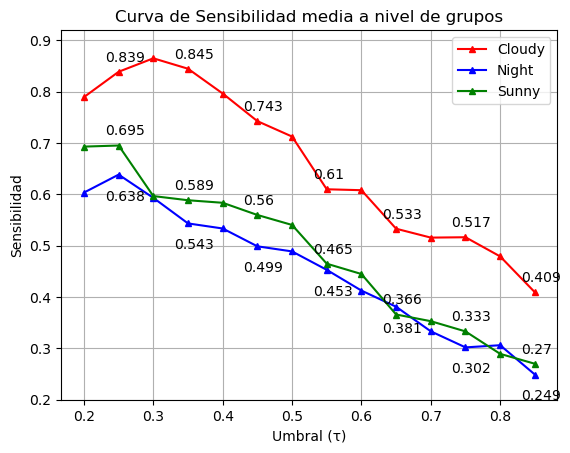

In [133]:
my_color=sb.color_palette('turbo',4) 

plt_diag=plt.axes()

plt_diag.plot(thr_arr,cloudy_R_cl,marker='^',markersize=5,color='r',label='Cloudy')
plt_diag.plot(thr_arr,night_R_cl,marker='^',markersize=5,color='b',label='Night')
plt_diag.plot(thr_arr,sunny_R_cl,marker='^',markersize=5,color='g',label='Sunny')
#plt_diag.plot(thr_arr,overall_ACC,marker='*',markersize=5,color=my_color[4], label= 'Overall_ACC')

for i in range(len(cloudy_ACC_overall)):
    if i%2!=0:
        plt_diag.text(thr_arr[i]-0.02,cloudy_R_cl[i]+0.02,np.round(cloudy_R_cl[i],3))
        plt_diag.text(thr_arr[i]-0.02,night_R_cl[i]-0.05,np.round(night_R_cl[i],3))
        plt_diag.text(thr_arr[i]-0.02,sunny_R_cl[i]+0.02,np.round(sunny_R_cl[i],3))

plt.legend()
plt.grid()
plt.ylim([0.2,0.92])
plt.xlabel('Umbral (τ)')
plt.ylabel('Sensibilidad')
plt.title('Curva de Sensibilidad media a nivel de grupos')

Print analitics result

[5. 5. 5. 4. 4. 5. 2.]
[0.65 0.7  0.75 0.8  0.85 0.9  0.95]
Trh =  0.8500000000000002 SH map=  0.79 SH query=  0.6715198877708438 ; P =  0.47971781302341293 ; R =  0.4778806584086709 ; P_overall =  0.65  ACC_overall =  0.9948529411764706
Trh =  0.65 SH map=  0.87 SH query=  0.6723649577764794 ; P =  0.6259740259470657 ; R =  0.6250601250325463 ; P_overall =  0.76  ACC_overall =  0.9945454545454545
Trh =  0.7000000000000001 SH map=  0.87 SH query=  0.6314248146280825 ; P =  0.642203742171472 ; R =  0.5556628056413053 ; P_overall =  0.75  ACC_overall =  0.9947368421052631
Trh =  0.7500000000000001 SH map=  0.8400000000000001 SH query=  0.5926862204144476 ; P =  0.5094642856891791 ; R =  0.4817261904550139 ; P_overall =  0.68  ACC_overall =  0.9937254901960785
Trh =  0.9000000000000002 SH map=  0.8300000000000001 SH query=  0.5936890352066977 ; P =  0.41362889981240025 ; R =  0.42668308700295016 ; P_overall =  0.65  ACC_overall =  0.9966346153846154


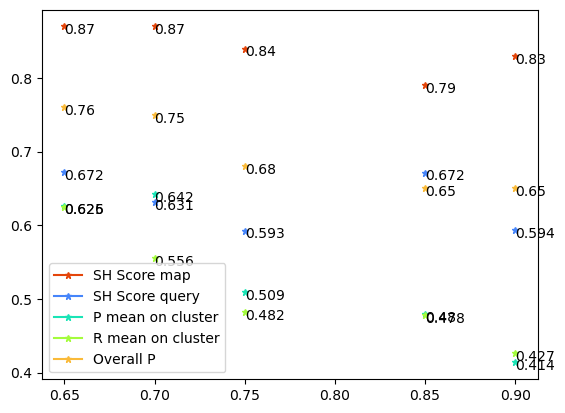

In [50]:
#Votacion:
k=6
n_winners=5
vot_arr=np.zeros(len(thr_arr))

sh_srot=np.argsort(pose_shscore_mean)
map_sh_sort=np.argsort(map_shscore_mean)
p_cl_sort=np.argsort(cluster_P_mean)
R_cl_sort=np.argsort(cluster_R_mean)
P_over_sort=np.argsort(overall_P)
ACC_sort=np.argsort(overall_ACC)

for i in range(1,k+1):
    vot_arr[map_sh_sort[-i]]+=1
    vot_arr[sh_srot[-i]]+=1
    vot_arr[p_cl_sort[-i]]+=1
    vot_arr[R_cl_sort[-i]]+=1
    vot_arr[P_over_sort[-i]]+=1

#Print resultado
print(vot_arr)
print(thr_arr)
sort_thr=np.round(thr_arr[np.argsort(vot_arr)],2)
winners=np.argsort(vot_arr)[-n_winners:]
for i in range(n_winners):
    print('Trh = ',thr_arr[winners[i]],'SH map= ',map_shscore_mean[winners[i]],'SH query= ',pose_shscore_mean[winners[i]],'; P = ',cluster_P_mean[winners[i]],'; R = ',cluster_R_mean[winners[i]],'; P_overall = ',overall_P[winners[i]],' ACC_overall = ',overall_ACC[winners[i]])


#Plot resultado
plt_winner=plt.axes()
my_color=sb.color_palette('turbo',5) 
for i in range(n_winners):
    plt_winner.plot(thr_arr[winners[i]],map_shscore_mean[winners[i]],marker='*',markersize=5,label='SH Score map',color=my_color[4])
    plt_winner.text(thr_arr[winners[i]],map_shscore_mean[winners[i]]-0.01,np.round(map_shscore_mean[winners[i]],3))
    plt_winner.plot(thr_arr[winners[i]],pose_shscore_mean[winners[i]],marker='*',markersize=5,label='SH Score query',color=my_color[0])
    plt_winner.text(thr_arr[winners[i]],pose_shscore_mean[winners[i]]-0.01,np.round(pose_shscore_mean[winners[i]],3))
    plt_winner.plot(thr_arr[winners[i]],cluster_P_mean[winners[i]],marker='*',markersize=5,label='P mean on cluster',color=my_color[1])
    plt_winner.text(thr_arr[winners[i]],cluster_P_mean[winners[i]]-0.01,np.round(cluster_P_mean[winners[i]],3))
    plt_winner.plot(thr_arr[winners[i]],cluster_R_mean[winners[i]],marker='*',markersize=5,label='R mean on cluster',color=my_color[2])
    plt_winner.text(thr_arr[winners[i]],cluster_R_mean[winners[i]]-0.01,np.round(cluster_R_mean[winners[i]],3))
    plt_winner.plot(thr_arr[winners[i]],overall_P[winners[i]],marker='*',markersize=5,label='Overall P',color=my_color[3])
    plt_winner.text(thr_arr[winners[i]],overall_P[winners[i]]-0.01,np.round(overall_P[winners[i]],3))

plt_winner.legend(['SH Score map','SH Score query','P mean on cluster','R mean on cluster','Overall P'])


In [51]:
k=5
print('Best threshold for sh score: ',thr_arr[np.argsort(pose_shscore_mean)[-k:]])
print('Best threshold for P mean on cluster score: ',thr_arr[np.argsort(cluster_P_mean)[-k:]])
print('Best threshold for R mean on score: ',thr_arr[np.argsort(cluster_R_mean)[-k:]])
print('Best threshold for P&R overall score: ',thr_arr[np.argsort(overall_P)[-k:]])
print('Best threshold for Accuracy overall score: ',thr_arr[np.argsort(overall_ACC)[-k:]])

Best threshold for sh score:  [0.9  0.95 0.7  0.85 0.65]
Best threshold for P mean on cluster score:  [0.85 0.8  0.75 0.65 0.7 ]
Best threshold for R mean on score:  [0.85 0.75 0.8  0.7  0.65]
Best threshold for P&R overall score:  [0.9  0.8  0.75 0.7  0.65]
Best threshold for Accuracy overall score:  [0.65 0.7  0.85 0.9  0.95]


### Conclusions:   

-Simple multiplication element by element:
    
     Trh = 0.28: quite good SH = 0.7657707075124908; P = 0.6847041846777927; R = 0.6897817460005248; P_overall = 0.8
         - nº clusters = 29 - Good
         - max nº nodes in cluster = 351 - Good
         - max dist (x,y) = (13.68,12.64) - Raised

-Harmonic mean
    
     Trh = 0.38: quite good SH query= 0.7336415517098903; P = 0.4833333333088463; R = 0.4494217686847402; P_overall = 0.6375
         - nº clusters = 63 - High
         - max nº nodes in cluster = 255 - Good
         - max dist (x,y) = (13.75,10.04) - Raised

     Trh = 0.48: good SH query= 0.7027618774560623 ; P = 0.4978632478333663 ; R = 0.4661477411207433 ; P_overall = 0.6375 ACC_overall = 0.9907051282051282
         - nº clusters = 91 - High
         - max nº nodes in cluster = 229 - Good
         - max dist (x,y) = (11.03,17,59) - Raised

-Geometric mean

     Trh = 0.65: good SH query= 0.6981712181384107 ; P = 0.6693693693259082 ; R = 0.644851994809988 ; P_overall = 0.7 ACC_overall = 0.992
         - nº clusters = 75 - High
         - max nº nodes in cluster = 236 - Good
         - max dist (x,y) = (16.07,11,25) - Raised

-Weighted average

     Trh = 0.75: good SH map= 0.9199999999999999 SH query= 0.6626599643229172 ; P = 0.671064814784089 ; R = 0.6316798941543383 ; P_overall = 0.84 ACC_overall = 0.9968627450980392
         - nº clusters = 102 - High
         - max nº nodes in cluster = 191 - Good
         - max dist (x,y) = (16.07,11,25) - Raised

-Similarity matrix

     Trh = 0.85: best case, goes wrong SH query= 0.5025083170276833 ; P = 0.4116465863094712 ; R = 0.418674698758258 ; P_overall = 0.55 ACC_overall = 0.9961206896551724
         - nº clusters = 232 - Very high
         - max nº nodes in cluster = 108 - Good
         - max dist (x,y) = (17.53,18.22) - Raised
         # With a higher threshold there are many nodes that are left out

## Evaluation - Criterion for Weight matrix

In this section iterate over the different criteria to compute the matrix of weights

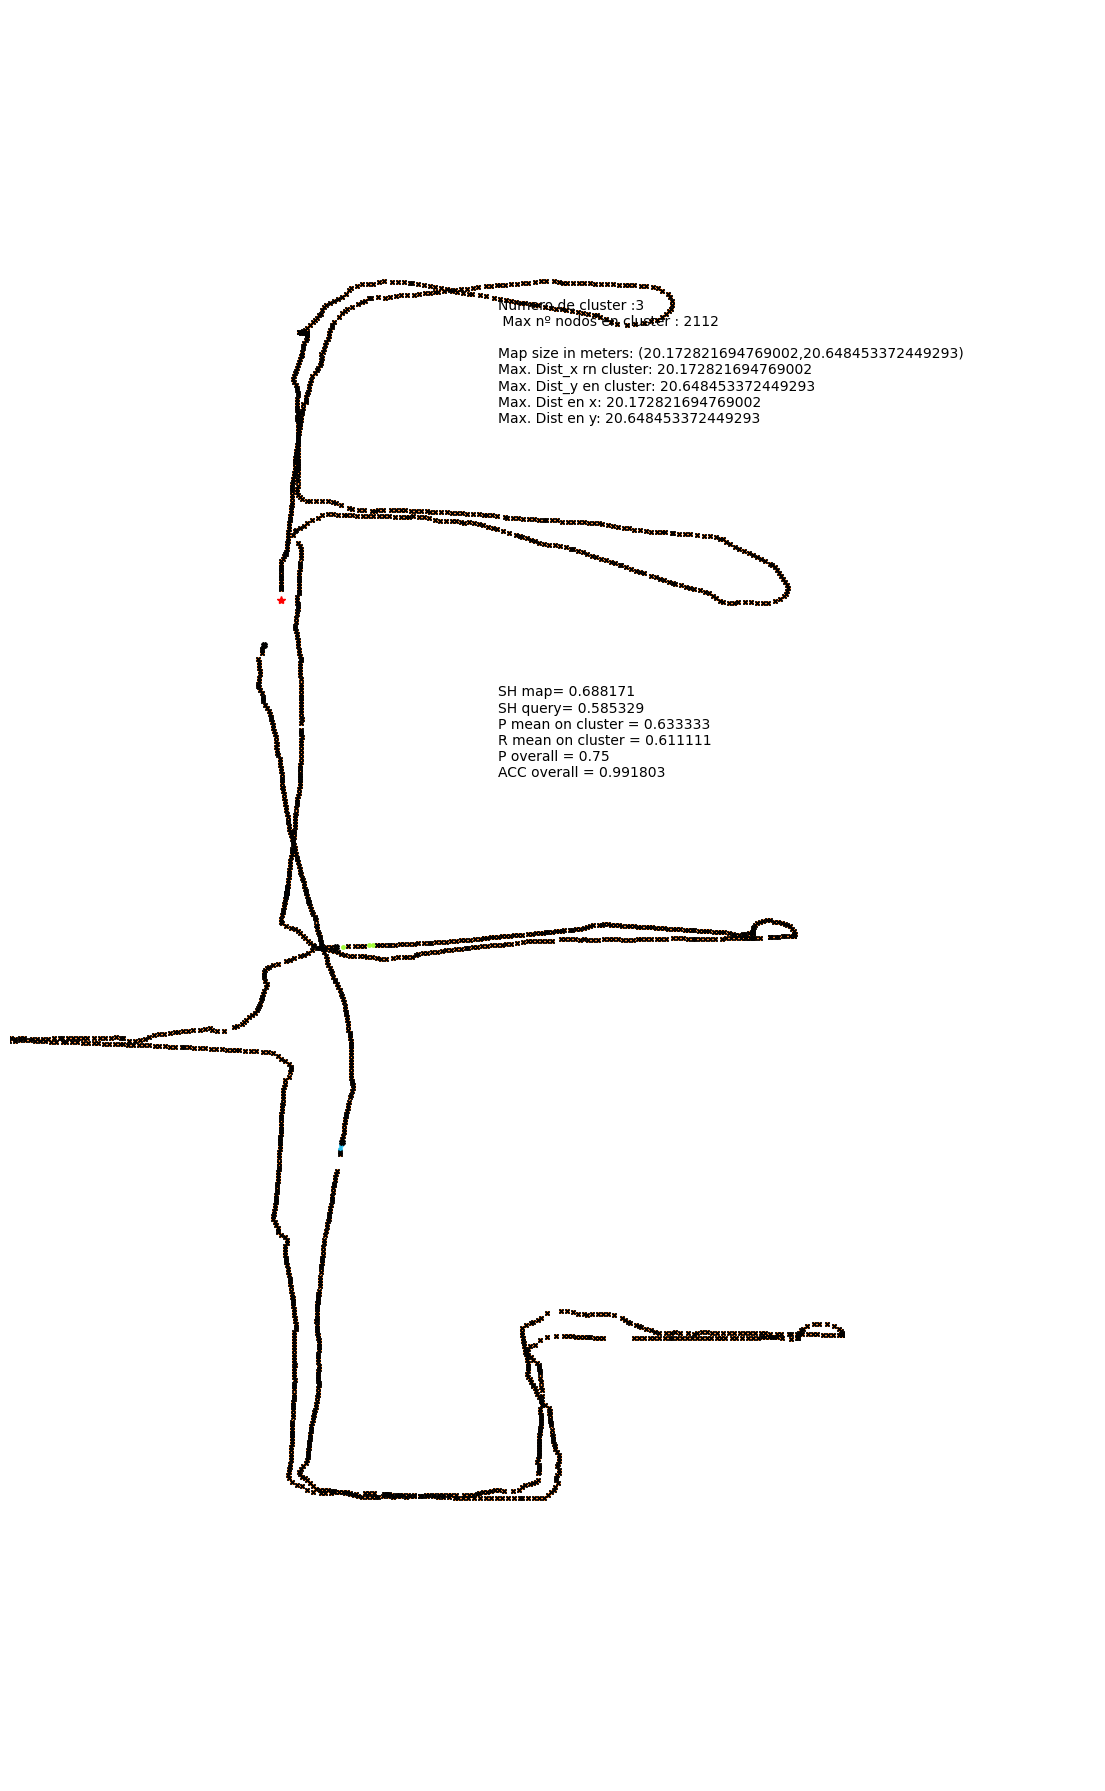

In [19]:
# Evaluation info arrays:
map_shscore_mean=[]
pose_shscore_mean=[]
cluster_P_mean=[]
cluster_R_mean=[]
overall_P=[]
overall_ACC=[]

# Bar diagrams arrays:
map_sh_diagram=[]
sh_diagram=[]
P_diagram=[]
R_diagram=[]


# Codification explain:
#   A = Multiplicacion simple elemento a elemento
#   B = Media harmonica elemento a elemento
#   C = Media geometrica
#   D = Media ponderada
#   F = Similarity matrix

criterion=['A','B','C','D','F']

sys.setrecursionlimit(15000000)
for v,c in enumerate(criterion):

    print('Create weighted graph class')
    graph=weighted_graph(weight,sim_matrix, cold_dataset,'COLD',peso=1.8,criterion=c)

    print('Clustering')
    clusters =graph.clusters(0.5, False,False)
    map_path=".../outputs/eval_map.json"
    map = graph.create_map(map_path,save=True)


    print('Run Place Recognition Evaluation')
    %run Place_Recognition.ipynb

    #Plot and save the map with poses
    print('Index: ',v)
    name='Criterion_'+criterion[v]+'_FINAL'
    path='.../Evaluation/'+name+'.png'
    eval_arr=np.array([map_sh_score_mean,sh_score_mean,P_mean,R_mean,P_,ACC_])
    graph.plot_map(path,eval_arr,save=False)

    map_shscore_mean.append(map_sh_score_mean)
    pose_shscore_mean.append(sh_score_mean)
    cluster_P_mean.append(P_mean)
    cluster_R_mean.append(R_mean)
    overall_P.append(P_)
    overall_ACC.append(ACC_)

    map_sh_diagram.append(map_pose_sh_diagram)
    sh_diagram.append(pose_sh_diagram)
    P_diagram.append(P)
    R_diagram.append(R)

    clear_output(wait=True)


pose_shscore_mean=np.array(pose_shscore_mean)
cluster_P_mean=np.array(cluster_P_mean)
cluster_R_mean=np.array(cluster_R_mean)
overall_P=np.array(overall_P)
overall_ACC=np.array(overall_ACC)

# Bar diagrams arrays:
map_sh_diagram=np.array(map_sh_diagram)
sh_diagram=np.array(sh_diagram)
P_diagram=np.array(P_diagram)
R_diagram=np.array(R_diagram)

Plot silhouette score diagram

In [ ]:
my_label=['Criterion %s'%(c) for c in criterion]
eval_label=['Eval pendiente = %s Tam weighted = %s'%(config_arr[0][i],config_arr[1][i]) for i in range(4)]
my_color=sb.color_palette('turbo',len(sh_diagram)) 

for i in range(sh_diagram.shape[0]):
    plt_diag=plt.axes()
    for j in range(sh_diagram.shape[1]):
        plt_diag.bar(sh_diagram[i][j],sh_diagram[i][j], width=1,color=my_color[j],label=my_label[j])

    plt_diag.xlabel(eval_label[i])
    plt_diag.legend(loc="upper left")
    plt.show()



Plot Silhouette Score comparation

In [ ]:
my_label=['Criterion %s'%(c) for c in criterion]
eval_label=['Eval pendiente = %s Tam weighted = %s',config_arr[0][i],config_arr[1][i] for i in range(4)]
my_color=sb.color_palette('turbo',len(sh_diagram)) 

plt_graph=plt.axes()

for i in range(sh_diagram.shape[1]):

    for j in range(sh_diagram.shape[0]):
        plt_diag.bar(sh_diagram[i][j],sh_diagram[i][j], width=1,color=my_color[j],label=my_label[j])

In [ ]:
print((pose_shscore_mean))
print(cluster_P_mean)
print(cluster_R_mean)
print(overall_P)
print(overall_ACC)

[0.2884657088811304, 0.4639673917613056, 0.3972815412330625, 0.44210950959956063]
[0.5, 0.625, 0.7, 0.8]
[0.3333333333333333, 0.45238095238095233, 0.6190476190476191, 0.8785714285714286]
[0.6875, 0.6375, 0.675, 0.75]
[0.9939320388349514, 0.988671875, 0.99, 0.993421052631579]


## Plot clusters

In [ ]:
import seaborn as sb
from Utils import geometry2 as geo
from scipy.spatial.transform import Rotation as R
from scipy.spatial.distance import cdist 
from Utils import load_utils

In [ ]:
train_dataset = load_utils.load_sequence(map_bin)

poses = train_dataset['poses']
feats_map = train_dataset['feats']
#clusters = train_dataset['clusters_list']
#cl_clasif = train_dataset['clusters']

Loaded poses: 2119 feats: 2119 odoms: 2119 im_paths: 2119 seq: 2119 test: 2119 clusters_list: 68 clusters_idx: 2119


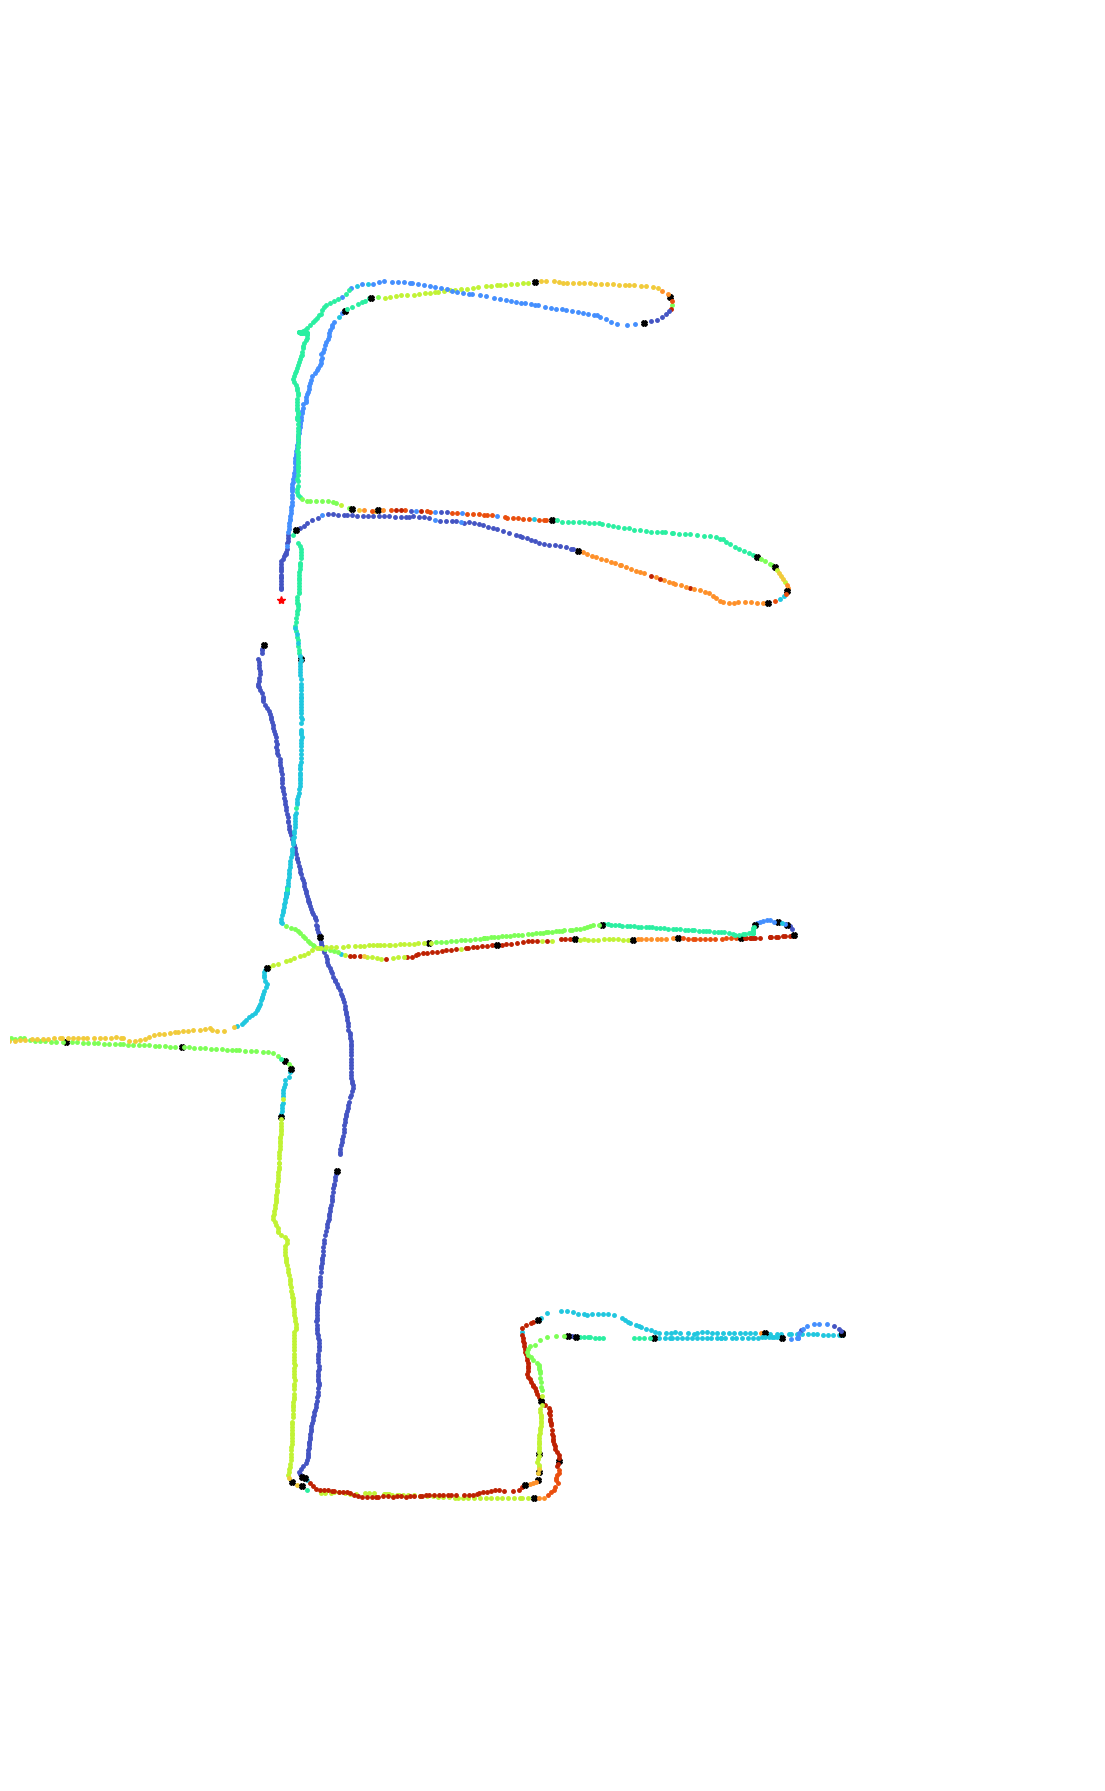

In [ ]:
n_clusters=len(clusters_bin)
my_colors=sb.color_palette('turbo',10) 
main_path='.../Evaluation'   #cambiar ruta


plt.figure(figsize=(14,23))
plt.plot(0,0,marker='*',color='red')
for i in range(n_clusters):
    idx=graph_bin.get_idx(clusters_bin[i])
    for j,item in enumerate(clusters_bin[i]):
        classif_idx=clusters_bin[i][j]
        translation=geo.SE2Poses.t(poses[item])
        new_x=translation[0]
        new_y=translation[1]   
        plt.plot(-new_y,new_x,markersize=2.5,marker='o',color=my_colors[i%10]) 
        
    plt.plot(-new_y,new_x,markersize=4,marker='X',color='black')
    plt.axis('off')
    plt.xlim([-2.5,7.5])
    plt.ylim([-20,10])

#plt.savefig(main_path+'clusters_bin_ovl.png')

In [ ]:
for threshold in rango_thr:
    #Make cut-graph:
    clusters, eval_info =graph.clusters(sup_thr=threshold)

    #Compute pose std desviation:
    sigma_x=[]
    sigma_y=[]
    sigma_theta=[]

    for cluster in cluster:
        print(poses[cluster,:].as_numpy())
        sigma_pose=np.std(poses[cluster,:].as_numpy(),axis=0)
        print(sigma_pose)
        sigma_x.append(sigma_pose[0])
        sigma_y.append(sigma_pose[1])
        sigma_theta.append(sigma_pose[2])
        break